For a couple of other ideas I want to explore, I need some "clumpy" sets of compounds: a group of compounds with a number of separate clusters of different sizes and cohesiveness (I'm not sure what the right word here is, I mean how tightly packed the cluster is). As I almost always do, I'm going to do this using data from ChEMBL and I will use groups of compounds from individual med chem papers as my clumps. Since I want clumpiness at different similarity ranges, I want to be able to find groups of "related" papers: papers with similar compounds. This post is a first step towards finding those related papers.

There's an [old ChEMBL blog post](https://chembl.blogspot.com/2013/09/document-similarity-in-chembl.html) about document similarity. Not too long after that, I did a [blog post](https://rdkit.blogspot.com/2013/12/finding-related-documents-in-chembl.html) with a related approach. This time instead of looking at the number of highly similar compounds between papers, I'm going to look at the median similarity between the compounds the papers..

I start by comparing at the distribution of similarities between compounds in med chem papers to those between papers in order to demonstrate that there is a significant difference there. To do this I pick a random sample of 20000 documents with between 20 and 100 compounds and use the usual Morgan fingerprint with radius 2 (there are plots below for radius 3 as well).

Here are the distributions of the median compound similarities within the papers and the median similarities between 500K random pairs of papers:
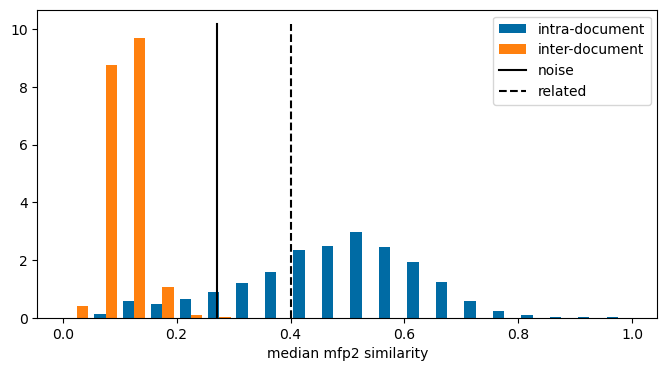
The plot also contains lines showing the threshold values for similarity between random compounds and related compounds taken from [this blog post](https://greglandrum.github.io/rdkit-blog/posts/2021-05-21-similarity-search-thresholds.html). Unsurprisingly, the intra-paper similarity values tend to be significantly higher than the inter-paper similarity values. The intra-paper similarity values tend to be above the "related" threshold value while the inter-paper values are below the "random" threshold value. 

Moving on to finding related documents.
One simple measure for document similarity is to count how many exact matches they have in common. This isn't particularly interesting for my purposes, so I chose to focus on pairs of documents that have high ratios of compounds that have similarities above the "related" threshold. Here's the overall distribution for fraction of exact matches, and fraction of pairs above the "random" and "related" thresholds for a set of 20 million random document pairs:
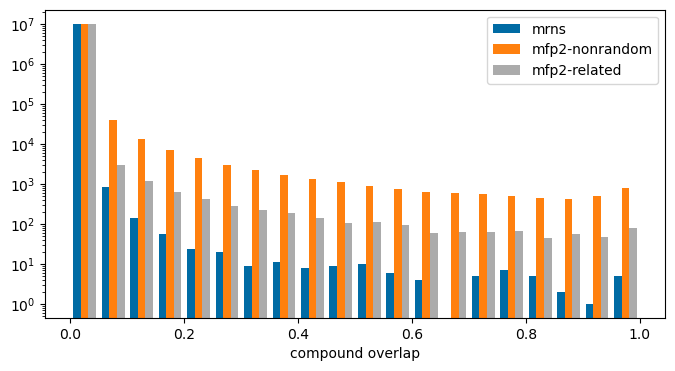

Looking through the papers with the highest "related" fraction shows that they contain peptides or other large molecules. This is less useful for me, so I'm going to come back to this in a follow-up post where I either limit the size of the compounds considered or use a count-based fingerprint to calculate similarity so that larger molecules don't automatically have higher similarity scores.|

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

from rdkit import DataStructs

import numpy as np

from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
%matplotlib inline
import psycopg2
%load_ext sql

import rdkit
print(rdkit.__version__)

2024.09.4


In [2]:
%config SqlMagic.feedback = False

# Data collection

Start by getting a collection of documents with between 20 and 100 compounds; this is my normal heuristic for trying to get med chem papers.

In [3]:
%sql postgresql://localhost/chembl_35 \
    select doc_id,count(distinct molregno) cnt into temporary table doc_compound_counts \
      from docs join compound_records using (doc_id) join compound_structures using (molregno) \
      group by (doc_id);

[]

In [4]:
%sql \
    select count(*) from doc_compound_counts where cnt>=20 and cnt<=100;

 * postgresql://localhost/chembl_35


count
34821


In [5]:
docs = %sql \
   select doc_id from doc_compound_counts tablesample bernoulli(80) repeatable (8723346) \
    where cnt>=20 and cnt<=100 limit 20000;
len(docs)

 * postgresql://localhost/chembl_35


20000

Generate fingerprints for the compounds from the papers

In [6]:
fpg2 = rdFingerprintGenerator.GetMorganGenerator(radius=2)
fpg3 = rdFingerprintGenerator.GetMorganGenerator(radius=3)

fps2 = {}
fps3 = {}
for doc_id in docs:
    doc_id = doc_id[0]
    pkls = %sql postgresql://localhost/chembl_35 \
        select molregno,mol_to_pkl(m) from rdk.mols join compound_records using (molregno) \
        where doc_id=:doc_id
    ms = [Chem.Mol(x[1].tobytes()) for x in pkls]
    fps2[doc_id] = fpg2.GetFingerprints(ms)
    fps3[doc_id] = fpg3.GetFingerprints(ms)


# Intra- and inter-paper similarity distributions

Calculate intra-paper similarity distributions

In [7]:
sims2 = {}
sims3 = {}
for idx,doc_id in enumerate(docs):
    if not idx%1000:
        print(f'Done {idx}')
    doc_id = doc_id[0]
    a = []
    fps = fps2[doc_id]
    for i in range(1,len(fps)):
        a.extend(DataStructs.BulkTanimotoSimilarity(fps[i],fps[0:i]))
    sims2[doc_id] = np.quantile(a,[0.5,0.9,0.95,0.99])
    a = []
    fps = fps3[doc_id]
    for i in range(1,len(fps)):
        a.extend(DataStructs.BulkTanimotoSimilarity(fps[i],fps[0:i]))
    sims3[doc_id] = np.quantile(a,[0.5,0.9,0.95,0.99])
    

Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
Done 14000
Done 15000
Done 16000
Done 17000
Done 18000
Done 19000


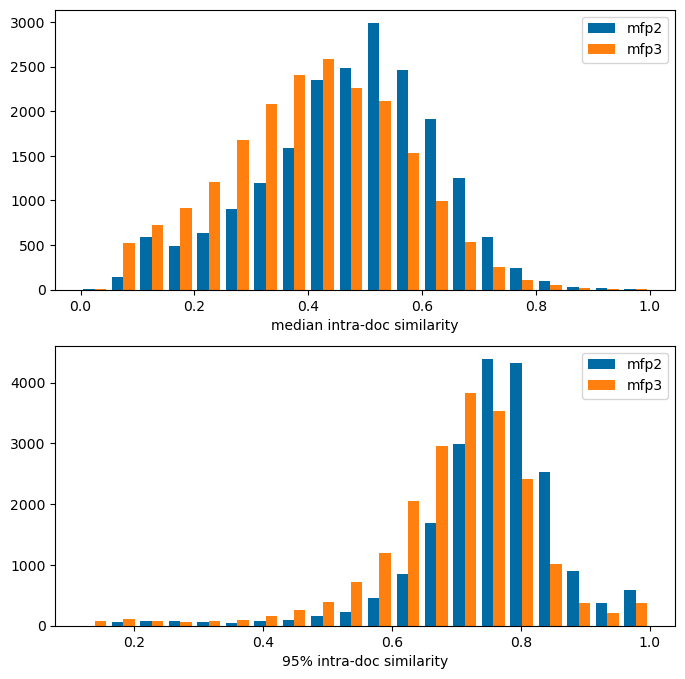

In [8]:
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.hist([[x[0] for x in sims2.values()],[x[0] for x in sims3.values()]],bins=20,label=(['mfp2','mfp3']));
plt.xlabel('median intra-doc similarity');
plt.legend();

plt.subplot(2,1,2)
plt.hist([[x[2] for x in sims2.values()],[x[2] for x in sims3.values()]],bins=20,label=(['mfp2','mfp3']));
plt.xlabel('95% intra-doc similarity');
plt.legend();

Now calculate the inter-paper similarity distributions; I'll choose 500,000 random pairs for this:

In [9]:
target = 500000

import random
import math
import time
# from: https://stackoverflow.com/a/55245866
def decode(i):
    k = math.floor((1+math.sqrt(1+8*i))/2)
    return k,i-k*(k-1)//2

def rand_pairs(n,m):
    return [decode(i) for i in random.sample(range(n*(n-1)//2),m)]

pairs = rand_pairs(len(docs),target)
pairs = [(docs[i][0],docs[j][0]) for i,j in pairs]
       
        
inter_sims2 = {}
related_sims2 = {}
inter_sims3 = {}
related_sims3 = {}
for idx in range(target):
    if not idx%(target//20):
        print(f'Done {idx}')
    di,dj = pairs[idx]
   
    a = []
    fpsi = fps2[di]
    fpsj = fps2[dj]
    for i in range(len(fpsi)):
        a.extend(DataStructs.BulkTanimotoSimilarity(fpsi[i],fpsj))
    inter_sims2[(di,dj)] = np.quantile(a,[0.5,0.9,0.95,0.99])
    related_sims2[(di,dj)] = (len([1 for x in a if x>0.27]),len([1 for x in a if x>0.4]),len(fpsi),len(fpsj))

    a = []
    fpsi = fps3[di]
    fpsj = fps3[dj]
    for i in range(len(fpsi)):
        a.extend(DataStructs.BulkTanimotoSimilarity(fpsi[i],fpsj))
    inter_sims3[(di,dj)] = np.quantile(a,[0.5,0.9,0.95,0.99])
    related_sims3[(di,dj)] = (len([1 for x in a if x>0.22]),len([1 for x in a if x>0.3]),len(fpsi),len(fpsj) )


Done 0
Done 25000
Done 50000
Done 75000
Done 100000
Done 125000
Done 150000
Done 175000
Done 200000
Done 225000
Done 250000
Done 275000
Done 300000
Done 325000
Done 350000
Done 375000
Done 400000
Done 425000
Done 450000
Done 475000


Compare the intra- and inter-paper distributions.

The line labeled noise in the plot below is the "noise level" for the fingerprint - the 95% threshold for similarity between random compound. The dashed line labeled "related" is the threshold level for compounds which are related to each other. You can find more information about these definitions in [this blog post](https://greglandrum.github.io/rdkit-blog/posts/2021-05-21-similarity-search-thresholds.html)

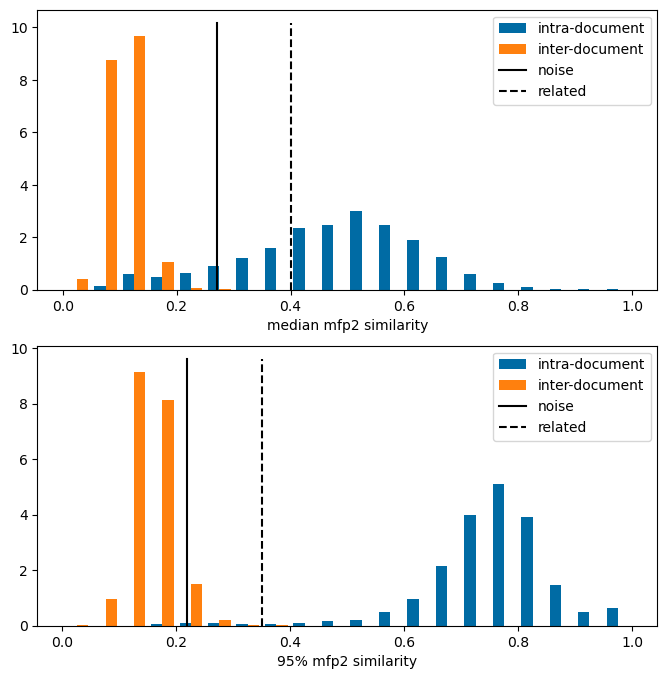

In [63]:
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.hist([[x[0] for x in sims2.values()],[x[0] for x in inter_sims2.values()]],bins=20,
         label=(['intra-document','inter-document']),density=True);
ymax = plt.ylim()[1]
plt.plot([0.27,0.27],[0,ymax],'k-',label='noise')
plt.plot([0.4,0.4],[0,ymax],'k--',label='related')
plt.xlabel('median mfp2 similarity');
plt.legend();

plt.subplot(2,1,2)
plt.hist([[x[2] for x in sims2.values()],[x[2] for x in inter_sims2.values()]],bins=20,
         label=(['intra-document','inter-document']),density=True);
ymax = plt.ylim()[1]
plt.plot([0.22,0.22],[0,ymax],'k-',label='noise')
plt.plot([0.35,0.35],[0,ymax],'k--',label='related')
plt.xlabel('95% mfp2 similarity');
plt.legend();

Get just the first of those plots, because that's what we'll use in the summary above:

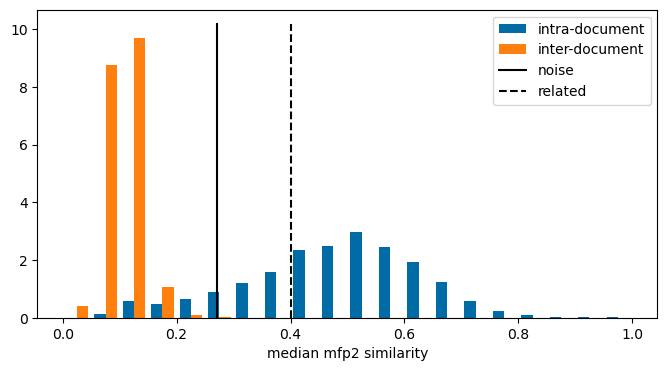

In [64]:
plt.figure(figsize=(8,4))

plt.hist([[x[0] for x in sims2.values()],[x[0] for x in inter_sims2.values()]],bins=20,
         label=(['intra-document','inter-document']),density=True);
ymax = plt.ylim()[1]
plt.plot([0.27,0.27],[0,ymax],'k-',label='noise')
plt.plot([0.4,0.4],[0,ymax],'k--',label='related')
plt.xlabel('median mfp2 similarity');
plt.legend();

In [68]:
np.quantile([x[0] for x in sims2.values()],[0.5,0.9,0.95,0.99])

array([0.48979592, 0.65753425, 0.7       , 0.78703901])

In [70]:
np.quantile([x[0] for x in inter_sims2.values()],[0.5,0.9,0.95,0.99])

array([0.10227273, 0.14      , 0.15306122, 0.18390805])

# Finding related documents


Get the molregnos for the compounds in all the papers. We will use these to identify overlapping compounds and to retrieve the compounds themselves

In [13]:
mrns = {}
for doc_id in docs:
    doc_id = doc_id[0]
    pkls = %sql postgresql://localhost/chembl_35 \
        select molregno from rdk.mols join compound_records using (molregno) \
        where doc_id=:doc_id
    mrns[doc_id] = [x[0] for x in pkls]

In [14]:
(len(docs)*(len(docs)-1))//2

199990000

I'll look at 10,000,000 random pairs of documents:

In [15]:
pairs2 = rand_pairs(len(docs),10000000)
pairs2 = [(docs[i][0],docs[j][0]) for i,j in pairs2]

For each pair calculate the number of compounds in common and the fractions of compound pairs with similarity values above the random and related thresholds.

In [31]:
mrn_overlaps = []
noise_sim_overlaps = []
related_sim_overlaps = []

for idx in range(len(pairs2)):
    if not idx%(len(pairs2)//20):
        print(f'Done {idx}')
    di,dj = pairs2[idx]
   
    mrnsi = set(mrns[di])
    mrnsj = set(mrns[dj])
    mrn_overlaps.append(len(mrnsi.intersection(mrnsj))/(len(mrnsi)+len(mrnsj)-len(mrnsi.intersection(mrnsj))))
    
    if (di,dj) not in related_sims2:
        a = []
        fpsi = fps2[di]
        fpsj = fps2[dj]
        for i in range(len(fpsi)):
            a.extend(DataStructs.BulkTanimotoSimilarity(fpsi[i],fpsj))
        inter_sims2[(di,dj)] = np.quantile(a,[0.5,0.9,0.95,0.99])
        related_sims2[(di,dj)] = (len([1 for x in a if x>0.27]),len([1 for x in a if x>0.4]),len(fpsi),len(fpsj))   
    
    noise,related,ni,nj = related_sims2[(di,dj)]
    denom = ni*nj
    noise_sim_overlaps.append(noise/denom)
    related_sim_overlaps.append(related/denom)
    


Done 0
Done 500000
Done 1000000
Done 1500000
Done 2000000
Done 2500000
Done 3000000
Done 3500000
Done 4000000
Done 4500000
Done 5000000
Done 5500000
Done 6000000
Done 6500000
Done 7000000
Done 7500000
Done 8000000
Done 8500000
Done 9000000
Done 9500000


In [71]:
len(inter_sims2),len([1 for v in inter_sims2.values() if v[0]>0.27]),len([1 for v in inter_sims2.values() if v[0]>0.4])

(10474902, 6329, 707)

Look at the fraction of exact matches, the fraction of pairs of compounds with similarity above the random threshold, and the fraction of pairs of compounds with similarity above the related threshold:

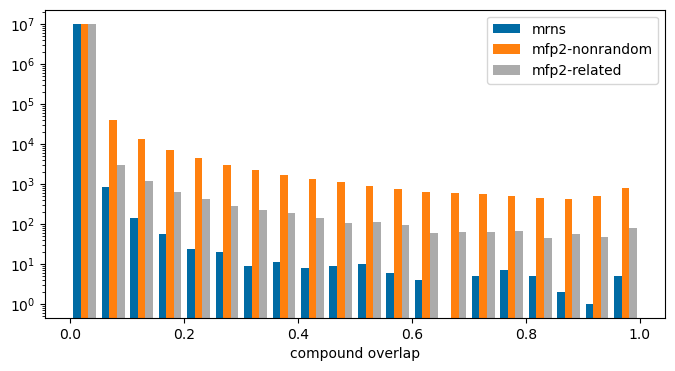

In [32]:
plt.figure(figsize=(8,4))

plt.hist([mrn_overlaps,noise_sim_overlaps,related_sim_overlaps],bins=20,log=True,
        label=('mrns','mfp2-nonrandom','mfp2-related'))
plt.xlabel('compound overlap');
plt.legend();

Let's look at an example with a high fraction of compounds above the noise level but a low fraction above the related level:

In [33]:
[(i,ovl,related_sim_overlaps[i]) for i,ovl in enumerate(noise_sim_overlaps) if ovl>0.5][:2]

[(1606, 0.5188034188034188, 0.09487179487179487),
 (5770, 0.5236270753512133, 0.14431673052362706)]

In [39]:
pairs2[1606]

(66679, 21372)

In [72]:
didi,didj = pairs2[1606]
pklsi = %sql postgresql://localhost/chembl_35 \
   select chembl_id,mol_to_pkl(m) from rdk.mols join compound_records using (molregno) \
    join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
    where doc_id=:didi
molsi = [(x,Chem.Mol(y.tobytes())) for x,y in pklsi]
pklsj = %sql postgresql://localhost/chembl_35 \
   select chembl_id,mol_to_pkl(m) from rdk.mols join compound_records using (molregno) \
    join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
    where doc_id=:didj
molsj = [(x,Chem.Mol(y.tobytes())) for x,y in pklsj]


In [73]:
len(molsi),len(molsj)

(45, 26)

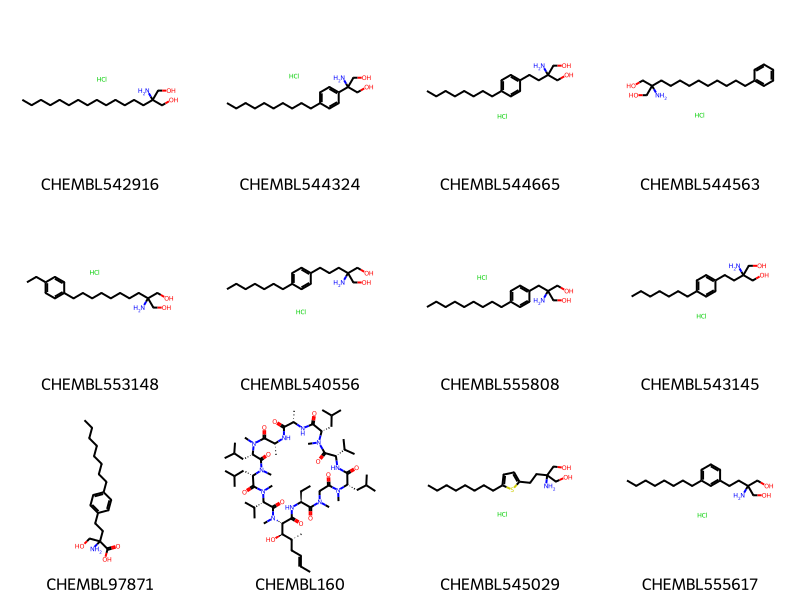

In [74]:
Draw.MolsToGridImage([y for x,y in molsi][:12],legends=[x for x,y in molsi],molsPerRow=4)

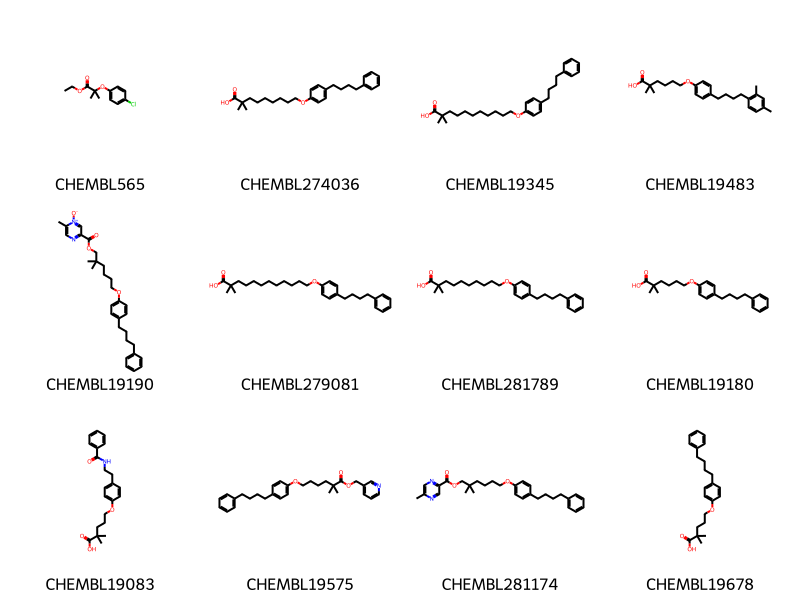

In [75]:
Draw.MolsToGridImage([y for x,y in molsj][:12],legends=[x for x,y in molsj],molsPerRow=4)

Anb bibliographic info on those:

In [76]:
%sql postgresql://localhost/chembl_35 \
    select doc_id,title,authors from docs where doc_id in (:didi,:didj)

doc_id,title,authors
9752,Synthesis and hypolipidemic activity of 2-substituted isobutyric acid derivatives.,"Morishita S, Saito T, Hirai Y, Shoji M, Mishima Y, Kawakami M."
15546,"Synthesis and immunosuppressive activity of 2-substituted 2-aminopropane-1,3-diols and 2-aminoethanols.","Kiuchi M, Adachi K, Kohara T, Minoguchi M, Hanano T, Aoki Y, Mishina T, Arita M, Nakao N, Ohtsuki M, Hoshino Y, Teshima K, Chiba K, Sasaki S, Fujita T."


Look about a pair with a high fraction of "related" structures but a small number of exact matches:

In [46]:
[(i,ovl,noise_sim_overlaps[i],mrn_overlaps[i]) for i,ovl in enumerate(related_sim_overlaps) if ovl>0.5][:2]

[(6704, 0.7841269841269841, 0.9206349206349206, 0.0),
 (34215, 0.5823095823095823, 0.8341523341523341, 0.03508771929824561)]

In [77]:
didi,didj = pairs2[6704]
pklsi = %sql postgresql://localhost/chembl_35 \
   select chembl_id,mol_to_pkl(m) from rdk.mols join compound_records using (molregno) \
    join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
    where doc_id=:didi
molsi = [(x,Chem.Mol(y.tobytes())) for x,y in pklsi]
pklsj = %sql postgresql://localhost/chembl_35 \
   select chembl_id,mol_to_pkl(m) from rdk.mols join compound_records using (molregno) \
    join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
    where doc_id=:didj
molsj = [(x,Chem.Mol(y.tobytes())) for x,y in pklsj]
len(molsi),len(molsj)

(21, 30)

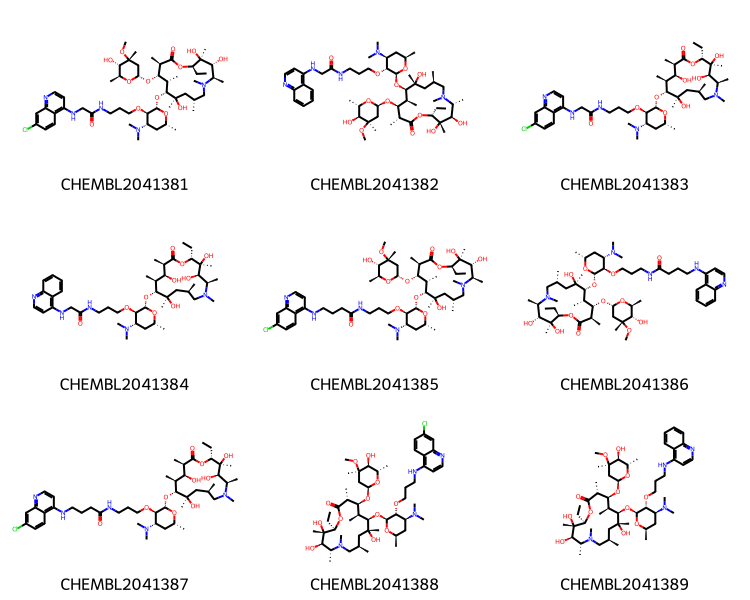

In [82]:
Draw.MolsToGridImage([y for x,y in molsi][1:10],legends=[x for x,y in molsi[1:]],molsPerRow=3,subImgSize=(250,200))

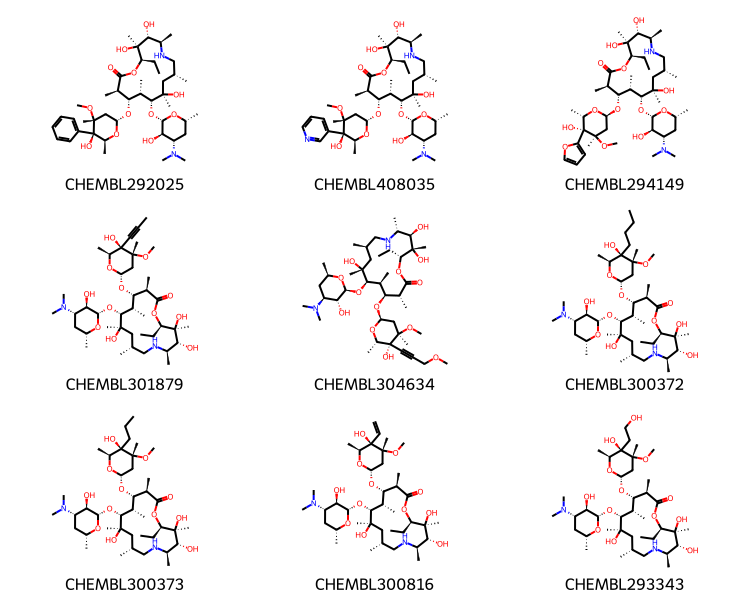

In [79]:
Draw.MolsToGridImage([y for x,y in molsj][1:10],legends=[x for x,y in molsj[1:]],molsPerRow=3,subImgSize=(250,200))

In [80]:
%sql postgresql://localhost/chembl_35 \
    select doc_id,title,authors from docs where doc_id in (:didi,:didj)

doc_id,title,authors
5559,"Synthesis, stereochemical assignment and biological activity of a novel series of C-4"" modified aza-macrolides.","Bronk BS, Letavic MA, Bertsche CD, George DM, Hayashi SF, Kamicker BJ, Kolosko NL, Norcia LJ, Rushing MA, Santoro SL, Yang BV."
62283,"Design, synthesis, and in vitro activity of novel 2'-O-substituted 15-membered azalides.","Pešić D, Starčević K, Toplak A, Herreros E, Vidal J, Almela MJ, Jelić D, Alihodžić S, Spaventi R, Perić M."


Order the document pairs by the median inter-document similarity.

In [87]:
ordered = sorted((v[0],k) for k,v in inter_sims2.items())
ordered.reverse()


In [90]:
[(k,inter_sims2[k],related_sims2[k]) for _,k in ordered[:10]]

[((12331, 7482),
  array([0.83809524, 0.91428571, 0.96      , 1.        ]),
  (594, 594, 27, 22)),
 ((93472, 15907),
  array([0.76190476, 0.82279986, 0.85034014, 0.88860906]),
  (1656, 1656, 46, 36)),
 ((14825, 9122),
  array([0.73387097, 0.9380531 , 0.9826087 , 1.        ]),
  (1817, 1817, 79, 23)),
 ((31412, 6280),
  array([0.71590909, 0.77286602, 0.81410256, 0.87204231]),
  (651, 651, 31, 22)),
 ((42121, 13617),
  array([0.71551724, 0.8411215 , 0.86538462, 0.91116191]),
  (1711, 1711, 59, 30)),
 ((2880, 923),
  array([0.71028037, 0.7979798 , 0.82501752, 0.89473684]),
  (2470, 2470, 26, 95)),
 ((65011, 5969),
  array([0.70748299, 0.78516762, 0.82269504, 0.86639801]),
  (1081, 1081, 24, 47)),
 ((46543, 4410),
  array([0.703125  , 0.83928571, 0.85714286, 1.        ]),
  (575, 575, 23, 25)),
 ((98553, 55691),
  array([0.7029703 , 0.84946237, 0.88172043, 0.92391304]),
  (716, 716, 36, 30)),
 ((10959, 923),
  array([0.69194824, 0.83333333, 0.88282071, 1.        ]),
  (4370, 4368, 46, 95))

In [109]:
didi,didj = ordered[0][1]
pklsi = %sql postgresql://localhost/chembl_35 \
   select chembl_id,mol_to_pkl(m) from rdk.mols join compound_records using (molregno) \
    join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
    where doc_id=:didi
molsi = [(x,Chem.Mol(y.tobytes())) for x,y in pklsi]
pklsj = %sql postgresql://localhost/chembl_35 \
   select chembl_id,mol_to_pkl(m) from rdk.mols join compound_records using (molregno) \
    join chembl_id_lookup on (molregno=entity_id and entity_type='COMPOUND') \
    where doc_id=:didj
molsj = [(x,Chem.Mol(y.tobytes())) for x,y in pklsj]


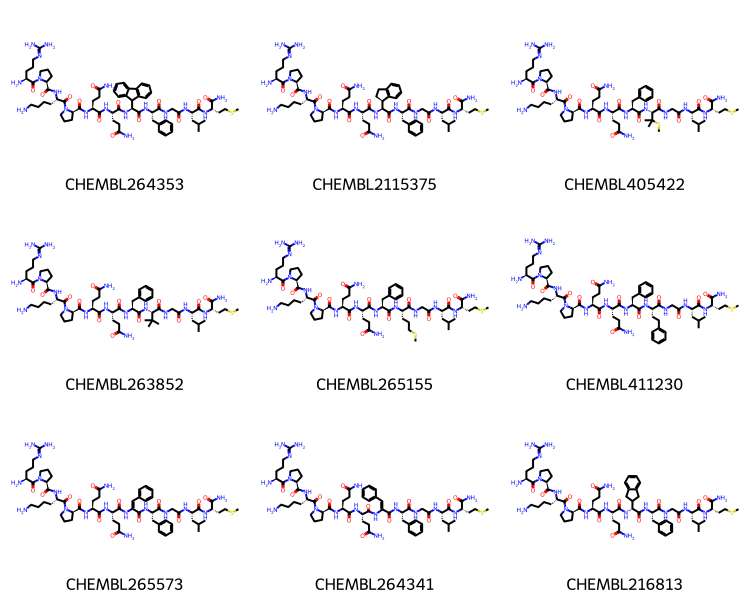

In [110]:
Draw.MolsToGridImage([y for x,y in molsi][1:10],legends=[x for x,y in molsi[1:]],molsPerRow=3,subImgSize=(250,200))

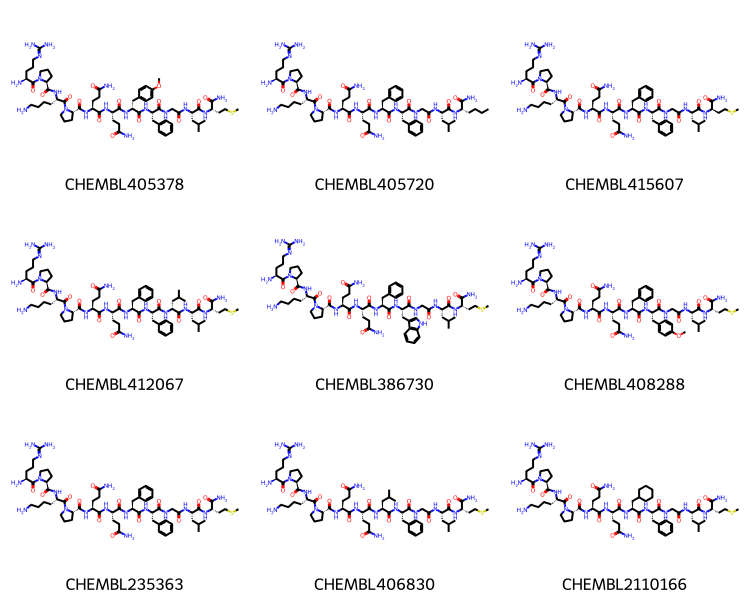

In [111]:
Draw.MolsToGridImage([y for x,y in molsj][1:10],legends=[x for x,y in molsj[1:]],molsPerRow=3,subImgSize=(250,200))

In [112]:
%sql postgresql://localhost/chembl_35 \
    select doc_id,title,authors from docs where doc_id in (:didi,:didj)

doc_id,title,authors
7482,Synthesis of peptides by the solid-phase method. 7. Substance P and analogues.,"Fournier A, Couture R, Regoli D, Gendreau M, St-Pierre S."
12331,Design and synthesis of side-chain conformationally restricted phenylalanines and their use for structure-activity studies on tachykinin NK-1 receptor.,"Josien H, Lavielle S, Brunissen A, Saffroy M, Torrens Y, Beaujouan JC, Glowinski J, Chassaing G."


I looked at a number of different highly ranked document pairs here and they all contain peptides or other fairly large molecules. This makes sense given that I am using a bit vector fingerprint for similarity, but isn't ideal for what I am trying to do. In a followup post I will explore a bit deeper into the list of highly ranked documents and/or try using count-based fingerprints.